In [1]:
import os
import sys
sys.path.append('/home/animesh/demo/project/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import torch
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch.utils.data as data
from vocabulary import Vocabulary
from PIL import Image
from tqdm import tqdm
import random
import json
import sys
from torchvision import transforms
import math
from data_loader import get_loader

In [2]:
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN,self).__init__()
        cnn = models.resnet50(pretrained = True)
        
        # gradient computation not required since model is pretrained
        for param in cnn.parameters():
            param.requires_grad_(False)
            
        # list(resnet.children())[:-1] gets a list of all the modules in the ResNet-50 model except for the last one, 
        # which is the fully connected layer that outputs the class scores. We exclude this layer because we want to 
        # replace it with our own embedding layer.
        
        self.cnn = nn.Sequential(*(list(cnn.children())[:-1])) 
        
        # This defines a new linear layer with input size equal to the number of features produced by the ResNet-50 model's 
        # last fully connected layer (i.e. resnet.fc.in_features) and output size equal to the specified embed_size. 
        # This linear layer maps the extracted image features to the embedding space.
        self.embedding = nn.Linear(cnn.fc.in_features, embed_size)
        
        
    # forward pass of batch of images through Resnet
    def forward(self, images):
        features = self.cnn(images)
        features = features.view(features.size(0),-1) 
        embedded_features = self.embedding(features)
        return embedded_features
    
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        
        # An embedding layer (nn.Embedding) that maps word indices to embedding vectors.
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # A linear layer (nn.Linear) that maps the LSTM hidden states to word scores, 
        # i.e., the probability distribution over the vocabulary.
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        
    
    def forward(self, features, captions):
        # captions[:,:-1] is a slice operation that selects all rows and all columns of the captions tensor, 
        # except for the last column.This is done to remove the last word index from each caption sequence because 
        # it is always the <end> token, which is not required as an input to the decoder network during training.
        embeddings = self.embed(captions[:,:-1])
        
        # Here, features.unsqueeze(1) adds an extra dimension to the features tensor at position 1, 
        # so that its shape becomes (batch_size, 1, feature_size). This is done to make the tensor compatible 
        # for concatenation with embeddings tensor, which has shape (batch_size, seq_length-1, embed_size).
        # The resulting tensor of concatenation has shape (batch_size, seq_length, embed_size) where seq_length 
        # is the length of the input caption sequence plus one (because we have concatenated the image features 
        # at the beginning of the sequence).
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        
        # an LSTM layer that takes in the concatenated tensor of image features and word embeddings as input.
        hiddens, _ = self.lstm(embeddings)
        
        # The resulting tensor outputs contains the scores of each word in the vocabulary at each time step, indicating 
        # the probability of the word being the next word in the caption sequence. 
        outputs = self.linear(hiddens)
        
        return outputs
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))
    
    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        # Initialize the hidden state
        hidden = self.init_hidden(inputs.shape[0])# features is of shape (batch_size, embed_size)
        
        out_list = list()
        word_len = 0
        
        with torch.no_grad():
            while word_len < max_len:
                lstm_out, hidden = self.lstm(inputs, hidden)
                out = self.linear(lstm_out)
                out = out.squeeze(1)
                out = out.argmax(dim=1)
                # print(out)
                out_list.append(out.item())
                
                inputs = self.embed(out.unsqueeze(0))
                
                word_len += 1
                if out == 1:
                    break
        
        return out_list

In [3]:
# Defining a transform to pre-process the testing images.
norm1 = (0.485, 0.456, 0.406)
norm2 = (0.229, 0.224, 0.225)
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm1,norm2)
])

In [4]:
import nltk
nltk.download('punkt')

batch_size = 128          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True 

# Build data loader.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.RandomVerticalFlip(0.1),
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize(norm1,      # normalize image for pre-trained model
                         norm2])

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)


[nltk_data] Downloading package punkt to /home/animesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████| 591753/591753 [00:44<00:00, 13268.86it/s]


In [5]:
# saved models to load.
encoder_file = 'encoder-5.pkl'
decoder_file = 'decoder-5.pkl'

#appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
data_s = data_loader.dataset
vocab_size = len(data_s.vocab)

# Initializing the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

# Loading the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

/home/animesh/demo/notebookenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/animesh/demo/notebookenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
def clean_sentence(output):
    parts = [data_loader.dataset.vocab.idx2word[i] for i in output][1:-1]
    sentence = " ".join(parts)
    return sentence

Please Enter the location of the folder in which the image is present :
/home/animesh/Downloads
Please enter the image filename with its jpg extension
test.jpg
Vocabulary successfully loaded from vocab.pkl file!


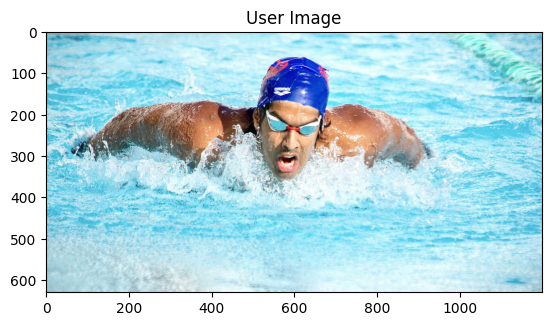

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


a man on a surfboard riding a wave .


In [7]:
from userdata_loader import user_loader

print("Please Enter the location of the folder in which the image is present :")
dst = input()
print("Please enter the image filename with its jpg extension")
file = input()
user_loader = user_loader(img_folders = dst,annotations_files = file,transform=transform_test,    
                         mode='test')

def user_prediction():
    orig_image, image = next(iter(user_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('User Image')
    plt.show()
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

user_prediction()

Vocabulary successfully loaded from vocab.pkl file!


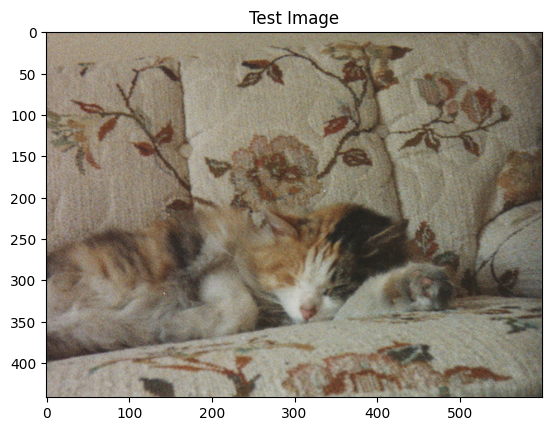

a cat laying on a bed with a blanket .


In [10]:
dat_loader = get_loader(transform=transform_test,    
                         mode='test')

def test_prediction():
    orig_image, image = next(iter(dat_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Test Image')
    plt.show()
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

test_prediction()

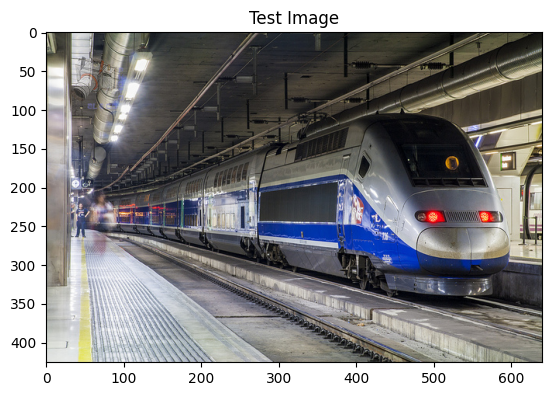

a train is pulling into a train station .


In [11]:
test_prediction()

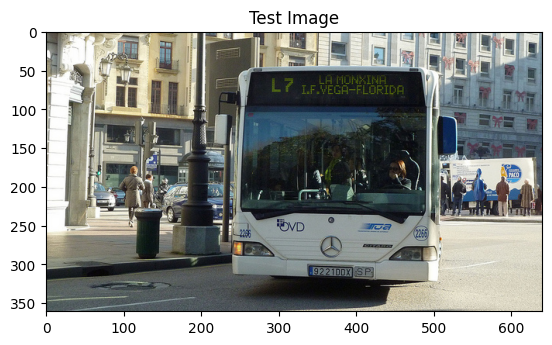

a bus is parked next to a building .


In [12]:
test_prediction()